**Collaboration Impact Analysis**

We are trying to find the impact of collaborations on a channel's popularity. In this part we will be defining the popularity of a channel by its mean number of views, as it provides a quantitative and easily interpretable measure of the channel's overall viewer engagement, capturing the average level of interest across its entire video content.

We will use the filtered dataset "dataframe_collaborations_videos" which is containing video data of the Gaming category for the 2016-2019 period, and an added column with the ids of channels identified in the videos. We will also use the "df_channels_en.tsv" dataset to find the names and number of subscribers of the channels.

In [50]:
#Import 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from itertools import product
import re
import seaborn as sns
import scipy.stats as stats
import os

# regression / matching
import statsmodels.formula.api as smf
import networkx as nx
from collections import defaultdict

In [157]:
DEFAULT_ENCODING = 'UTF8'

# Read in data
def read_csv(file, chunk_size=30000): 
    file_path = os.path.join('/Users/loudba/Documents/EPFL/Applied_data_analysis/ada-2023-project-adacadabra/processed_data', file)
    chunk_list = []  # List to hold chunks
    for chunk in pd.read_csv(file_path, encoding=DEFAULT_ENCODING, chunksize=chunk_size):
        chunk_list.append(chunk)
    # Concatenate chunks into single DataFrame
    df = pd.concat(chunk_list, ignore_index=True)
    return df

df_collab_videos = read_csv('dataframe_collaborations_videos.csv')
df_collab_videos = df_collab_videos.copy()
display(df_collab_videos)


,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,final_collaborator_ids
0,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.790269,0.0,y5IvyZlzELs,3442,9.0,2016-09-26,1253.0,NaN
1,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:28.334071,0.0,m1agc0qT0BY,2407,8.0,2016-09-25,2311.0,NaN
2,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:32.174979,1.0,rr6tfbBA9iY,1820,11.0,2016-09-24,5596.0,NaN
3,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:25.379061,0.0,ZGll5_wD9Ys,1209,8.0,2016-09-21,792.0,NaN
4,Gaming,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:26.020550,426.0,kYkokQgnu20,2053,2076.0,2016-09-21,1141393.0,NaN
...,...,...,...,...,...,...,...,...,...,...
9166272,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:06.375078,12.0,s6mBrPKvumc,558,368.0,2018-09-26,10397.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166273,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.025547,16.0,qneHrPX4_AY,363,574.0,2018-09-25,13954.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166274,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:07.684503,32.0,4H4Oz0Rjd70,713,596.0,2018-09-24,24198.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."
9166275,Gaming,UCrwIEEqUWswVQ_L_VzfeR-Q,2019-11-11 17:26:08.371065,65.0,c_34mr0tXDk,1306,1301.0,2018-09-23,93020.0,"['UCmiLzX1rvItY08BJmjwWZjQ', 'UChEkBnuYDNrP8tg..."


First we are adding a column to the dataset to get the number of channels identified in each video. Then we create a new table containing the channel ids, their corresponding mean view count and average number of collaborations per video.

We are also using the second dataset to add a column with the number of subscribers of each channel.


In [158]:
# Create a new column with the number of collaborators per video, put 0 if the video has no collaborators
df_collab_videos['collaboration_count'] = df_collab_videos['final_collaborator_ids'].apply(lambda x: 0 if pd.isna(x) else len(x.split(',')))

# Group the dataframe by channel_id and calculate the mean of view_count and final_collaborator_ids
channels_table= df_collab_videos.groupby('channel_id').agg({
    'view_count': 'mean',
    'collaboration_count': 'mean'
}).reset_index()

# Rename the columns
channels_table.columns = ['channel', 'mean_view_count', 'mean_final_collaboration_count']

# Load dataset containing the number of subscribers per channel
channels_path = './data/df_channels_en.tsv.gz'
df_channels = pd.read_csv(channels_path, sep ='\t',compression='gzip')
df_channels = df_channels[['channel', 'subscribers_cc']]

# Merge the two tables
channels_table = channels_table.merge(df_channels, left_on='channel', right_on='channel', how='left')

# Sort the table by mean_view_count in descending order to have most popular channels first
channels_table.sort_values('mean_view_count', ascending=False, inplace=True)

# Display the new table
display(channels_table)


,channel,mean_view_count,mean_final_collaboration_count,subscribers_cc
12333,UCPcynnZcILjm0e2aaaTuCjw,3.821617e+08,1.666667,8470000
5539,UCAxx_o1ClhGY0PBJZ7Ge3uA,5.006198e+07,2.000000,94600
3559,UC6jvGhVm8JSCNwU1Y13BfZw,2.980671e+07,0.000000,963000
19201,UCd4iew3AeLPRSCWwu2OitEw,2.532518e+07,0.000000,1950000
15845,UCWv_20ptZMar2TDswm6wYLg,2.358715e+07,0.000000,759000
...,...,...,...,...
24330,UCnuzgY3qOvnjXumbV2vIj7w,1.138979e+01,0.000000,20000
26603,UCssVEinRlfmSxXGsvMDNHPQ,1.100000e+01,0.000000,11000
8571,UCHTnlUv7rDFz15XCO5vVi-Q,6.000000e+00,0.000000,10960
19917,UCeeC8yDOjtFl-zE0jDOKrWg,4.000000e+00,0.000000,13300


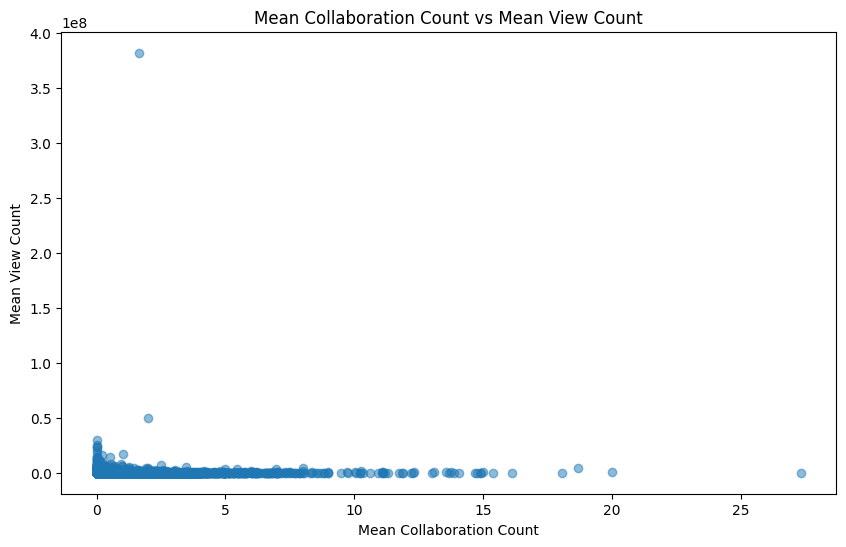

In [159]:
# Plot mean view count vs mean collaboration count
plt.figure(figsize=(10, 6))
plt.scatter(channels_table['mean_final_collaboration_count'],channels_table['mean_view_count'], alpha=0.5)
plt.xlabel('Mean Collaboration Count')
plt.ylabel('Mean View Count')
plt.title('Mean Collaboration Count vs Mean View Count')
plt.show()

There are two problems with the above graph : all of the points are aggregated close to the origin. To remedy this problem we remove the outliers using z-score, and we use a logarithmic scale for the y-axis.

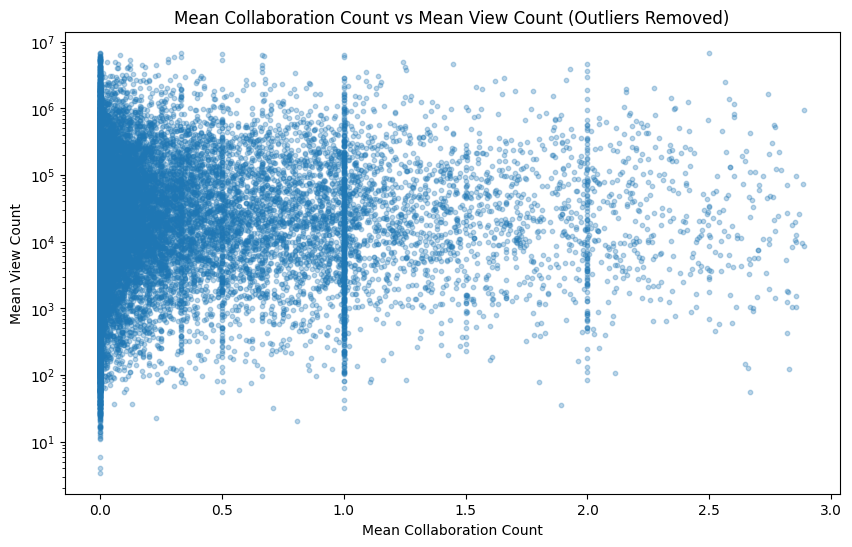

In [161]:
# Remove outliers using z-score
z_scores = stats.zscore(channels_table[['mean_view_count', 'mean_final_collaboration_count']])
threshold = 3
channels_table_without_outliers = channels_table[(np.abs(z_scores) < threshold).all(axis=1)]


# Plot mean view count vs mean collaboration count
plt.figure(figsize=(10, 6))
plt.scatter(channels_table_without_outliers['mean_final_collaboration_count'],channels_table_without_outliers['mean_view_count'], alpha=0.3, s =10)

plt.xlabel('Mean Collaboration Count')
plt.ylabel('Mean View Count') 
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title('Mean Collaboration Count vs Mean View Count (Outliers Removed)')
plt.show()




We can see that most Youtubers don't do any collaborations, or only a few. A few lines appear for whole numbers of collaborations. It can be interpreted in different ways :
- Collaborations are not evenly distributed among YouTubers. Many creators may prefer to work independently or may find it logistically challenging to collaborate frequently.
- The dataset studied may not contain enough videos for each channel.

The number of collaborations does not seems to have an impact on the number of views. We are making a Welch ttest to compare the views between people that never collaborate and people who do.

In [166]:
# Separate channels with mean_collaboration_count of 0 and others
channels_with_zero_collab = channels_table_without_outliers[channels_table_without_outliers['mean_final_collaboration_count'] == 0]
channels_with_nonzero_collab = channels_table_without_outliers[channels_table_without_outliers['mean_final_collaboration_count'] > 0]

# Perform Welch's t-test
t_stat, p_value = stats.ttest_ind(channels_with_zero_collab['mean_view_count'], channels_with_nonzero_collab['mean_view_count'], equal_var=False)

print("Mean view count for zero collab:", channels_with_zero_collab['mean_view_count'].mean())
print("Mean view count for non zero collab:", channels_with_nonzero_collab['mean_view_count'].mean())

print(p_value)
# Check if the p-value is less than 0.05 (significance level)
if p_value < 0.05:
    print("There is a significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others.")
else:
    print("There is no significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others.")


Mean view count for zero collab: 114706.62960351165
Mean view count for non zero collab: 112122.6860974477
0.5878659194080699
There is no significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others.


We find that doing collaborations don't have an impact on the popularity of channels. However, maybe collaborations don't have an impact overall but can have an impact on certain categories of Youtubers (for example non popular Youtubers). 

To discuss this, we thought of considering the number of subscribers to a channel as a measure of popularity, meaning that channels with more subscribers will tend to have more views. To avoid big Youtubers squashing the impact of collaborations on small Youtubers, we first normalized the average number of views by the number of subscribers to the channel, and repeated the same comparison as before.
Results were not concluding, and we arrived to the conclusion that subscribers are not a good popular metric. 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


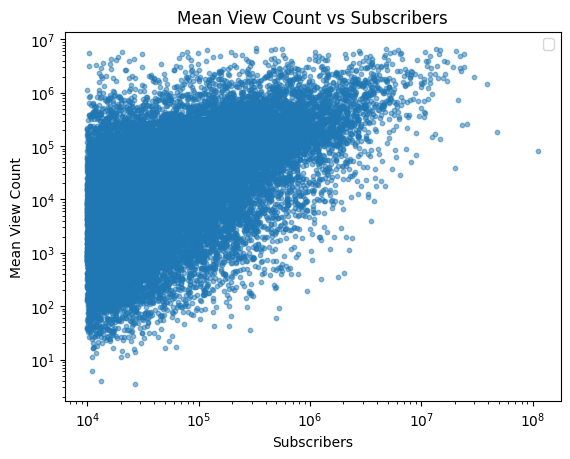

In [167]:
plt.scatter(channels_table_without_outliers['subscribers_cc'], channels_table_without_outliers['mean_view_count'], alpha=0.5, s=10)
plt.xlabel('Subscribers')
plt.ylabel('Mean View Count')

plt.xscale('log')
plt.yscale('log')
plt.title('Mean View Count vs Subscribers')
plt.legend()

plt.show()

Indeed, when we plot the mean view count per video versus the number of subscribers we can see that there is not a direct correlation. 
Two Youtubers with the same number of subscribers (for example 10 000) can have very different number of views in their videos (either 10 or 10 000 000). 

To study the impact of collaborations on Youtubers with different popularity we will then use the mean number of views as before but separate them in 10 groups using their number of views.

Bin: (3.4330000000000003, 791.191]
Mean view count divided for channels with mean_collaboration_count of 0: 339.51422403648075
Mean view count divided for channels with mean_collaboration_count of > 0: 401.9365219023488
p-value: 1.8537374406662203e-12
len bin: 2940
There is a significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others in this bin.

Bin: (791.191, 2420.333]
Mean view count divided for channels with mean_collaboration_count of 0: 1478.3353319104779
Mean view count divided for channels with mean_collaboration_count of > 0: 1541.641782343516
p-value: 0.00027453750456465567
len bin: 2941
There is a significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others in this bin.

Bin: (2420.333, 5198.203]
Mean view count divided for channels with mean_collaboration_count of 0: 3688.7371199800905
Mean view count divided for channels with mean_collaboration_count of > 0: 3745.75

/var/folders/gx/bfgpp2gn7q9d5ddxfmsvdz080000gn/T/ipykernel_14004/1037606892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channels_table_without_outliers['mean_view_count_bin'] = pd.qcut(channels_table_without_outliers['mean_view_count'], q=10)
/var/folders/gx/bfgpp2gn7q9d5ddxfmsvdz080000gn/T/ipykernel_14004/1037606892.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_label, bin_df in channels_table_without_outliers.groupby('mean_view_count_bin'):


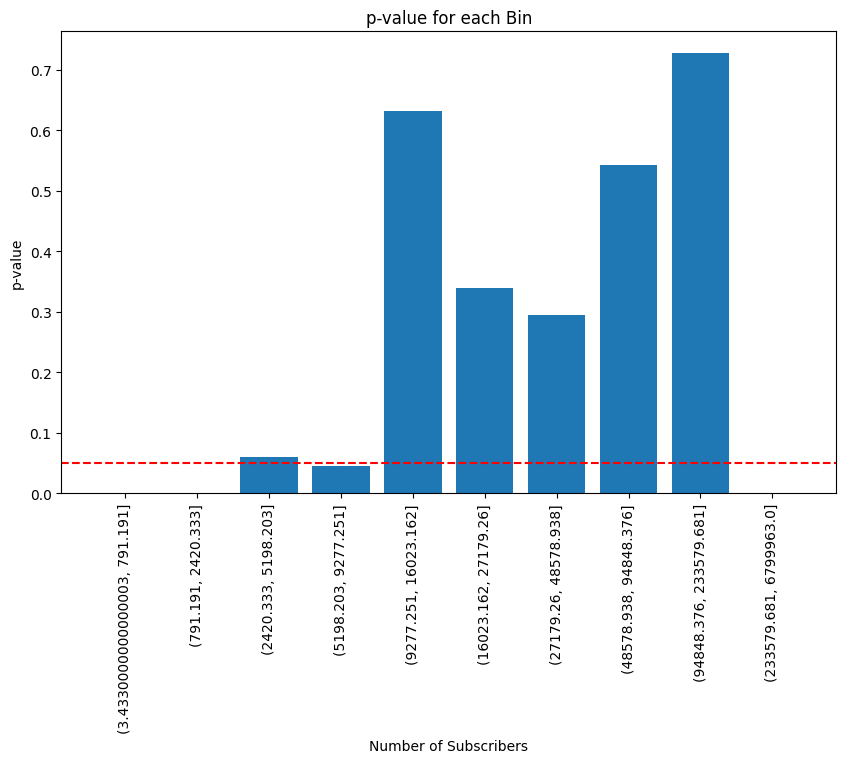

In [168]:
# Divide merged_table_without_outliers into 10 bins based on subscribers_cc
channels_table_without_outliers['mean_view_count_bin'] = pd.qcut(channels_table_without_outliers['mean_view_count'], q=10)

# Create a list to store the p-values
p_values = []
bin_labels = []

# Perform t-test for each bin
for bin_label, bin_df in channels_table_without_outliers.groupby('mean_view_count_bin'):
    channels_with_zero_collab = bin_df[bin_df['mean_final_collaboration_count'] == 0]
    channels_with_nonzero_collab = bin_df[bin_df['mean_final_collaboration_count'] > 0]
    
    # Perform Welch's t-test
    t_stat, p_value = stats.ttest_ind(channels_with_zero_collab['mean_view_count'], channels_with_nonzero_collab['mean_view_count'], equal_var=False)
    print("Bin:", bin_label)
    print("Mean view count divided for channels with mean_collaboration_count of 0:", channels_with_zero_collab['mean_view_count'].mean())
    print("Mean view count divided for channels with mean_collaboration_count of > 0:", channels_with_nonzero_collab['mean_view_count'].mean())
    print("p-value:", p_value)
    print("len bin:", len(bin_df))
    if p_value < 0.05:
        print("There is a significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others in this bin.")
    else:
        print("There is no significant difference in the mean number of views between channels with mean_collaboration_count of 0 and others in this bin.")
    print()
    
    # Append the p-value to the list
    p_values.append(p_value)
    bin_labels.append(str(bin_label))


# Plot the p-values
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, p_values)
plt.axhline(y=0.05, color='red', linestyle='--')
plt.xlabel('Number of Subscribers')
plt.ylabel('p-value')
plt.title('p-value for each Bin')

# Rotate the x-axis labels
plt.xticks(rotation='vertical')

plt.show()


Even if overall collaborations does not have an impact on the popularity of a Youtuber we can see that it is not true for all bins. While for most collaborations don't have an impact, for small Youtubers (that don't make a lot of views) this result is not true anymore. For those who have less than 2420.333 views in average the ttest suggests that Youtubers that collaborate will tend to have more views than those who don't.

Another result is that for really big Youtubers, collaborations also have an impact but a negative one. 

In [123]:
channels_table_without_outliers.sort_values('mean_view_count', ascending=False, inplace=True)
display(channels_table_without_outliers)


/var/folders/gx/bfgpp2gn7q9d5ddxfmsvdz080000gn/T/ipykernel_14004/62609457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_table_without_outliers.sort_values('mean_view_count', ascending=False, inplace=True)


,channel_id,mean_view_count,mean_final_collaboration_count,mean_view_count_bin
25741,UCqxgIQs2EwEuAppj4B2vVLA,6.799963e+06,2.500000,"(233579.681, 6799963.0]"
29770,UCz_yk8mDSAnxJq0ar66L4sw,6.675913e+06,0.000000,"(233579.681, 6799963.0]"
7563,UCFMOW7zjCVT7k3va5bHSYqg,6.665669e+06,0.333333,"(233579.681, 6799963.0]"
22519,UCkDbxGSyvOgR8UJj3m0GC6Q,6.664194e+06,0.000000,"(233579.681, 6799963.0]"
13053,UCR4s1DE9J4DHzZYXMltSMAg,6.529849e+06,0.000000,"(233579.681, 6799963.0]"
...,...,...,...,...
24330,UCnuzgY3qOvnjXumbV2vIj7w,1.138979e+01,0.000000,"(3.4330000000000003, 791.191]"
26603,UCssVEinRlfmSxXGsvMDNHPQ,1.100000e+01,0.000000,"(3.4330000000000003, 791.191]"
8571,UCHTnlUv7rDFz15XCO5vVi-Q,6.000000e+00,0.000000,"(3.4330000000000003, 791.191]"
19917,UCeeC8yDOjtFl-zE0jDOKrWg,4.000000e+00,0.000000,"(3.4330000000000003, 791.191]"
